# 2024 CITS4012 Project

# Readme

notes for marker

# 1. Dataset Processing

## Import the libraries

In [74]:
import re
import json
import nltk
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

## Loading the datasets

In [91]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [66]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
output_y = [["<BOS>"] + [y] for y in training_y]
target_y = [[y] + ["<EOS>"]for y in training_y]
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [67]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Sentiment Distribution
sentiment_distribution = train_data['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Sentiment Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)         

## Data Preprocessing

In [68]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
      --------------------------------------- 0.3/12.8 MB 2.3 MB/s eta 0:00:06
     - -------------------------------------- 0.5/12.8 MB 3.2 MB/s eta 0:00:04
     -- ------------------------------------- 0.8/12.8 MB 3.8 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/12.8 MB 4.1 MB/s eta 0:00:03
     ---- ----------------------------------- 1.3/12.8 MB 4.3 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 4.4 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.5 MB/s eta 0:00:03
     ------ --------------------------------- 1.9/12.8 MB 4.4 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 4.7 MB/s eta 0:00:03
     ------- -------------------------------- 2.5/12.8 MB

In [69]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(x):
    doc = nlp(x)
    x = [word.text for word in doc if not word.is_stop]
    return x

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(x):
    x = [stemmer.stem(word) for word in x]
    return x

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = remove_stopwords(sentence)             # Remove stopwords / Tokenise
        # tokens = stem(tokens)                           # Stemming
        # tokens = lemmatize(tokens)                      # Lemmatisation
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

In [72]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {"<BOS>": 0, "<EOS>": 1}

review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews, aspects and polarities
for sentence in polarity+aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

In [73]:
def tokens_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def aspects_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Token index lists for training data
train_x_idx = tokens_to_index(train_x_token, word_to_idx)
train_a_idx = aspects_to_index(training_a, word_to_idx)
output_y_idx = tokens_to_index(output_y, word_to_idx)
target_y_idx = tokens_to_index(target_y, word_to_idx)

## Pretrained Word Embeddings from Glove

In [78]:
glove_model = api.load("glove-twitter-50")
glove_weights = torch.FloatTensor(glove_model.vectors)

In [79]:
print(glove_weights.size())

torch.Size([1193514, 50])


# 2. Model Implementation

## Model 1 (Word Embedding + Aspect Embedding)

In [75]:
# Encoder
class LSTMEncoder1(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(LSTMEncoder1, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        word_embedding = torch.cat((aspect_embedding, word_embedding), 0)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class LSTMDecoder1(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1, num_layers=1, attention='dot_product'):
        super(LSTMDecoder1, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == 'cosine_similarity':
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)

        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output, attn_weights.squeeze(0)
    
    def forward(self, input, hidden, cell, encoder_hiddens):
        word_embedding = self.embedding(input).view(1, 1, -1)
        word_embedding = self.dropout(word_embedding)
        _, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        concat_output, attn_weights = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, cell, attn_weights
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [80]:
# Set the seed for reproducibility
seed = 4012
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_epochs = 10000
display_interval = 500
learning_rate = 0.01
hidden_size = 50
attention_type = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'
embedding = nn.Embedding.from_pretrained(glove_weights)
# embedding = nn.Embedding(vocab_size, hidden_size)

encoder1 = LSTMEncoder1(hidden_size, embedding, num_layers=1)
decoder1 = LSTMDecoder1(hidden_size, vocab_size, embedding, dropout_p=0.1, num_layers=1, attention=attention_type)

encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0

for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = [[idx] for idx in target_y_idx[random_idx]]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor(y_index)
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)
    y_length = y_tensor.size(0)
    
    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder1.hidden_size) # For attention mechanism
    encoder_hidden = encoder1.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden, encoder_cell = encoder1(x_tensor[i], encoder_hidden, a_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    decoder_input = torch.tensor([[word_to_idx["<BOS>"]]]) 
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # Feed the y_tensor (polarity) into the decoder with teacher forcing
    for i in range(y_length):
        decoder_output, decoder_hidden, decoder_cell, _ = decoder1(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens)
        loss += criterion(decoder_output, y_tensor[i])
        decoder_input = y_tensor[i]

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item() / y_length
    total_loss += loss
    plot_losses.append(loss)
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [500/10000], Loss: 2.7294
Epoch [1000/10000], Loss: 0.6433
Epoch [1500/10000], Loss: 0.5802
Epoch [2000/10000], Loss: 0.5593
Epoch [2500/10000], Loss: 0.5519
Epoch [3000/10000], Loss: 0.5375
Epoch [3500/10000], Loss: 0.5188
Epoch [4000/10000], Loss: 0.5109
Epoch [4500/10000], Loss: 0.4930
Epoch [5000/10000], Loss: 0.5056
Epoch [5500/10000], Loss: 0.4777
Epoch [6000/10000], Loss: 0.4721
Epoch [6500/10000], Loss: 0.4802
Epoch [7000/10000], Loss: 0.4754
Epoch [7500/10000], Loss: 0.4928
Epoch [8000/10000], Loss: 0.4834
Epoch [8500/10000], Loss: 0.4732
Epoch [9000/10000], Loss: 0.4885
Epoch [9500/10000], Loss: 0.4741
Epoch [10000/10000], Loss: 0.4847


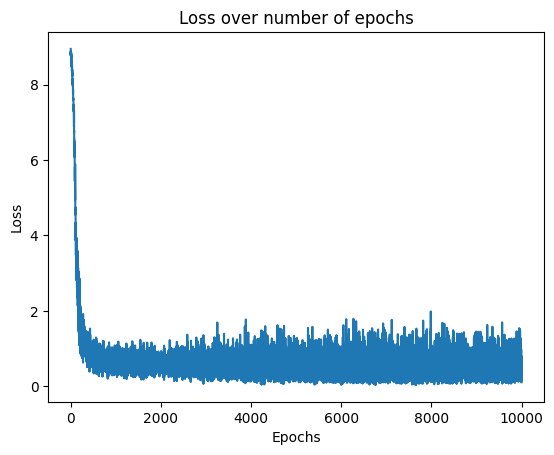

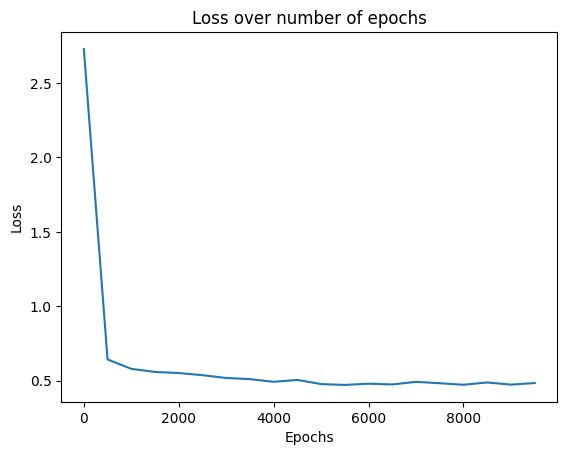

In [81]:
# Save the model
torch.save(encoder1, 'Model1/encoder1.pt')
torch.save(decoder1, 'Model1/decoder1.pt')

# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, display_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

## Model 2 (Aspect Embedding + Attention Mechanism)

In [102]:
# Encoder
class LSTMEncoder2(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(LSTMEncoder2, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden):
        word_embedding = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class LSTMDecoder2(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1, num_layers=1, attention='dot_product'):
        super(LSTMDecoder2, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        keys = encoder_hiddens.T.unsqueeze(0).repeat(2, 1, 1)
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, keys), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, keys) * scale, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0).repeat(2, 1, 1))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, input, hidden, cell, encoder_hiddens, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        word_embedding = self.dropout(word_embedding)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        embedded = torch.cat((word_embedding, aspect_embedding), dim=-1)
        out, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        hidden_aspect = torch.cat((out, aspect_embedding), dim=0)
        concat_output = self.cal_attention(hidden_aspect, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [103]:
# Set the seed for reproducibility
seed = 4012
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_epochs = 10000
display_interval = 500
learning_rate = 0.01
hidden_size = 50
attention_type = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'
embedding = nn.Embedding(vocab_size, hidden_size)

encoder2 = LSTMEncoder2(hidden_size, embedding, num_layers=1)
decoder2 = LSTMDecoder2(hidden_size, vocab_size, embedding, dropout_p=0.1, num_layers=1, attention=attention_type)

encoder_optimizer = optim.SGD(encoder2.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder2.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0 
for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = [[idx] for idx in target_y_idx[random_idx]]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor(y_index)
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)
    y_length = y_tensor.size(0)
    
    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder2.hidden_size) # For attention mechanism
    encoder_hidden = encoder2.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden, encoder_cell = encoder2(x_tensor[i], encoder_hidden)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    decoder_input = torch.tensor([[word_to_idx["<BOS>"]]]) 
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # Feed the y_tensor (polarity) into the decoder with teacher forcing
    for i in range(y_length):
        decoder_output, decoder_hidden, decoder_cell = decoder2(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens, a_tensor)
        loss += criterion(decoder_output, y_tensor[i])
        decoder_input = y_tensor[i]

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item() / y_length
    total_loss += loss
    plot_losses.append(loss)
    
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

SyntaxError: 'break' outside loop (501244605.py, line 24)

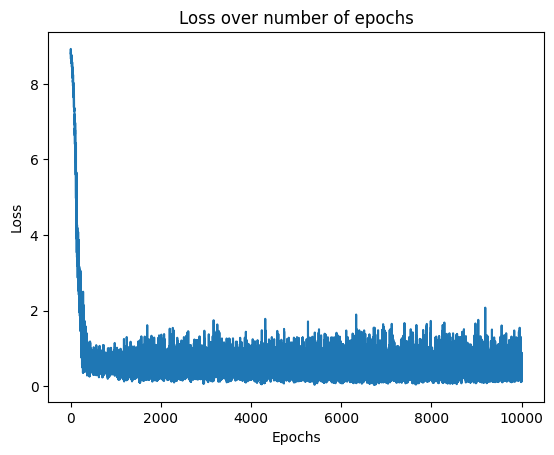

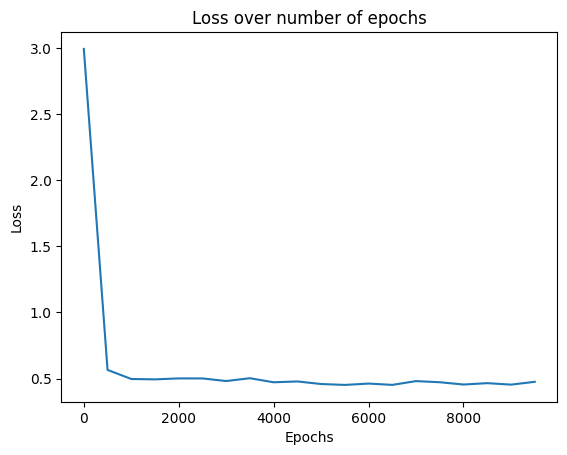

In [ ]:
# Save the model
torch.save(encoder2, 'Model2/encoder2.pt')
torch.save(decoder2, 'Model2/decoder2.pt')

# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, display_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

## Model 3 (Combined)

In [ ]:
# Encoder
class LSTMEncoder3(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(LSTMEncoder3, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        word_embedding = torch.cat((aspect_embedding, word_embedding), 0)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
# Decoder
class LSTMDecoder3(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1, num_layers=1, attention='dot_product'):
        super(LSTMDecoder3, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        keys = encoder_hiddens.T.unsqueeze(0).repeat(2, 1, 1)
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, keys), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, keys) * scale, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0).repeat(2, 1, 1))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, input, hidden, cell, encoder_hiddens, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        word_embedding = self.dropout(word_embedding)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        embedded = torch.cat((word_embedding, aspect_embedding), dim=-1)
        out, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        hidden_aspect = torch.cat((out, aspect_embedding), dim=0)
        concat_output = self.cal_attention(hidden_aspect, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [ ]:
# Set the seed for reproducibility
seed = 4012
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_epochs = 10000
display_interval = 500
learning_rate = 0.01
hidden_size = 50
attention_type = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'
embedding = nn.Embedding(vocab_size, hidden_size)

encoder3 = LSTMEncoder3(hidden_size, embedding, num_layers=1)
decoder3 = LSTMDecoder3(hidden_size, vocab_size, embedding, dropout_p=0.1, num_layers=1, attention=attention_type)

encoder_optimizer = optim.SGD(encoder3.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder3.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0
for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = [[idx] for idx in target_y_idx[random_idx]]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor(y_index)
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)
    y_length = y_tensor.size(0)
    
    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder3.hidden_size) # For attention mechanism
    encoder_hidden = encoder3.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden, encoder_cell = encoder3(x_tensor[i], encoder_hidden, a_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    decoder_input = torch.tensor([[word_to_idx["<BOS>"]]]) 
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # Feed the y_tensor (polarity) into the decoder with teacher forcing
    for i in range(y_length):
        decoder_output, decoder_hidden, decoder_cell = decoder3(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens, a_tensor)
        loss += criterion(decoder_output, y_tensor[i])
        decoder_input = y_tensor[i]

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item() / y_length
    total_loss += loss
    plot_losses.append(loss)
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [500/10000], Loss: 2.9251
Epoch [1000/10000], Loss: 0.5472
Epoch [1500/10000], Loss: 0.4893
Epoch [2000/10000], Loss: 0.4959
Epoch [2500/10000], Loss: 0.4961
Epoch [3000/10000], Loss: 0.4923
Epoch [3500/10000], Loss: 0.4778
Epoch [4000/10000], Loss: 0.4997
Epoch [4500/10000], Loss: 0.4639
Epoch [5000/10000], Loss: 0.4733
Epoch [5500/10000], Loss: 0.4514
Epoch [6000/10000], Loss: 0.4362
Epoch [6500/10000], Loss: 0.4570
Epoch [7000/10000], Loss: 0.4474
Epoch [7500/10000], Loss: 0.4724
Epoch [8000/10000], Loss: 0.4669
Epoch [8500/10000], Loss: 0.4487
Epoch [9000/10000], Loss: 0.4528
Epoch [9500/10000], Loss: 0.4482
Epoch [10000/10000], Loss: 0.4711


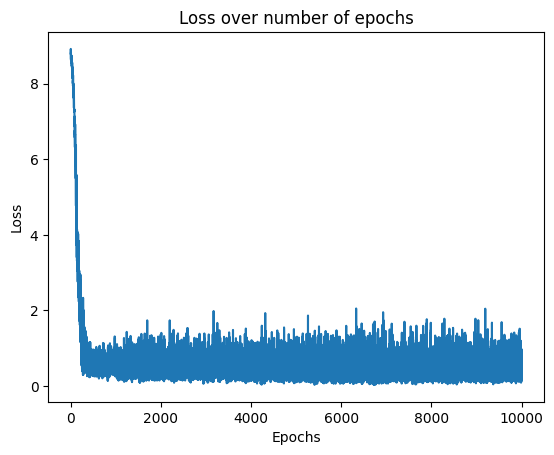

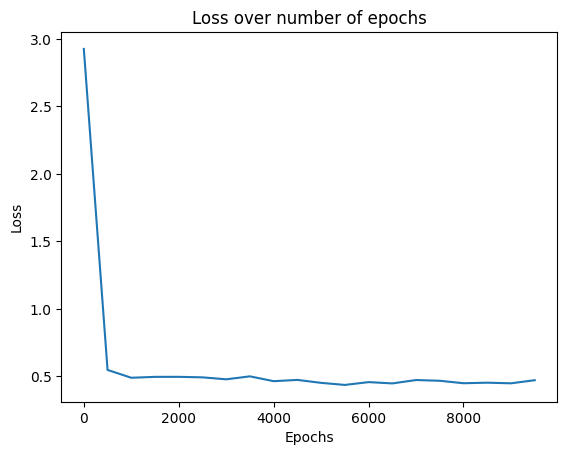

In [ ]:
# Save the model
torch.save(encoder3, 'Model3/encoder3.pt')
torch.save(decoder3, 'Model3/decoder3.pt')

# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, display_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

# 3. Testing and Evaluation

## Model 1

In [82]:
# LSTM evaluate
def LSTMevaluate1(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = word_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, asp_tensor)
            encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.LongTensor([[word_to_idx["<BOS>"]]]) 
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        decoded_words = []

        attention_weights = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, attn_weights = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens)
            attention_weights.append(attn_weights.squeeze().tolist())  # Append attention weights
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == word_to_idx["<EOS>"]:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(word_list[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, attention_weights

In [135]:
! pip install colorama

In [136]:
from colorama import Fore, Style

def print_highlighted_sentence(sentence, attention_weights):
    input_tokens = sentence.split()
    
    # Normalize attention weights to range [0, 1]
    max_weight = max(attention_weights)
    normalized_weights = [weight / max_weight for weight in attention_weights]
    
    # Iterate over each token and print with color highlighting based on attention weight
    for token, weight in zip(input_tokens, normalized_weights):
        if weight > 0.5:  # Use green color for high attention weights
            highlighted_text = f"{Fore.GREEN}{token}{Style.RESET_ALL}"
        elif weight < 0.5:  # Use red color for low attention weights
            highlighted_text = f"{Fore.RED}{token}{Style.RESET_ALL}"
        else:  # Use default color for neutral attention weights
            highlighted_text = token
        
        print(highlighted_text, end=" ")  # Print the highlighted word with space

In [145]:
# Test the LSTM model using the test data
for i in range(len(test_x[:10])):
    polarity, attn_weights = LSTMevaluate1(encoder1, decoder1, test_x[i], test_a[i])
    print(f"Predicted polarity: {polarity[0]}, Actual polarity: {test_y[i]}")
    print(attn_weights[0],'\n')
    print_highlighted_sentence(test_x[i], attn_weights[0])
    print()

Predicted polarity: neutral, Actual polarity: neutral
[0.011694168671965599, 0.03998936340212822, 0.29529672861099243, 0.03157969191670418, 0.08769087493419647, 0.08551080524921417, 0.01406841166317463, 0.016208218410611153, 0.01205373089760542, 0.038646988570690155, 0.02251391112804413, 0.02192271500825882, 0.08769087493419647, 0.038646988570690155, 0.012216734699904919, 0.033687058836221695, 0.06530740112066269, 0.03526315465569496, 0.006314167287200689, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256, 0.0020808554254472256] 

We went again and sat at the bar this time, I had 5 pi

In [84]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity, _ = LSTMevaluate1(encoder1, decoder1, test_x[i], test_a[i])
    if polarity[0] == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5716


## Model 2

In [ ]:
# LSTM evaluate
def LSTMevaluate2(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = word_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden)
            encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.LongTensor([[word_to_idx["<BOS>"]]]) 
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        decoded_words = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens, asp_tensor)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == word_to_idx["<EOS>"]:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(word_list[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
# Test the LSTM model using the test data
for i in range(len(test_x[:10])):
    polarity = LSTMevaluate2(encoder2, decoder2, test_x[i], test_a[i])[0]
    print(f"Predicted polarity: {polarity}, Actual polarity: {test_y[i]}")

Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: positive, Actual polarity: positive
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative


In [ ]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity = LSTMevaluate2(encoder2, decoder2, test_x[i], test_a[i])[0]
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6104


## Model 3

In [ ]:
# LSTM evaluate
def LSTMevaluate3(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = word_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, asp_tensor)
            encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.LongTensor([[word_to_idx["<BOS>"]]]) 
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        decoded_words = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens, asp_tensor)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == word_to_idx["<EOS>"]:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(word_list[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
# Test the LSTM model using the test data
for i in range(len(test_x[:10])):
    polarity = LSTMevaluate3(encoder3, decoder3, test_x[i], test_a[i])[0]
    print(f"Predicted polarity: {polarity}, Actual polarity: {test_y[i]}")

Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: positive, Actual polarity: positive
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative


In [ ]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity = LSTMevaluate3(encoder3, decoder3, test_x[i], test_a[i])[0]
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6049
